# Forecasting a time series

In [30]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Intro to Time Series

### Univariate vs. Multivariate Time Series
- Univariate time series containing a sequence of one feature 
- Multivariate time series containing a sequence of multiple features

### Use Cases
1. Predicting future values of this time series
2. Imputation predicting missing values

### Conventions
- When dealing with time series we batches are normaly organized as followed: _[batch_size, time_stamps, dimensionality]_
- Univariate time series:  _[batch_size, time_stamps, 1]_
- Multivariate time series: _[batch_size, time_stamps, feature_num]_

### LSTMs and GRUs
- In this notebook we use simple RNNs Cells. 
- In praxis GRUs or LSTMs are used, because: 
    - Normal RNNs cell loss knowledge about the first inputs when handling long sequences
    - LSTMs and GRUs have a long-term memomry. The network learns what to store in the long-term memory. 

## Basic Ideas of RNN

Each Neuron (!) propagates back in time:   
    - The input will be concatenated with the hidden state _h(t)_.   
    - The first _h(t)_ = 0   
    - Afterwards the concatenated input goes trough an activation function - mostly _tanh()_
    - The output y(t) becomes the new h(t) and this happends again for n-time-stamps

<img src="../../img/1501.png" />

## Deep RNNs

<img src="../../img/1507.png" />

```python
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
```

### Notes to Deep RNN: 
1. Was zurzeit am meisten Sinn macht für mich:  
    Die Units sind die time_stamps (t)
    Jedes Neuron entfaltet sich, t -mal, abhängig der timestemps. Also eine GRU-Zelle entfalltet sich t-mal
    
_Convention: # [batch_size, time steps, input dimensions]_

# Creating the time series

### Helper function for creating time serie


__What are the Time steps?__

Input Features of RNN are normally represented as [batch_size, time steps, dimensionality]

In [31]:
def generate_time_series(batch_size, n_steps):
    # Generates a univariate time series
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # Creates an array of given shape (4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [32]:
def plt_history(history: "history"):
    df = pd.DataFrame(history.history)
    df.plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)

In [33]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [34]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

## Analysing Data

In [35]:
ts = generate_time_series(32, 100) #32 Timeseries each 100 time stemps long

In [36]:
ts.shape # Time series with [batch_size, time_stamps, num_features]

(32, 100, 1)

In [41]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1) # n_steps +1 generate us a label, [batch_size, time_stemps, num_features]
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # We take the first 7000 Batches for Training, Our Y is everything from the 7000th batch containing only the last value of the ts
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1] 

In [50]:
X_train.shape # Contains the first 7000 Batches with each 50 time stamps

(7000, 50, 1)

In [51]:
y_train.shape # COntains only the last time stamp for every batch

(7000, 1)

### Plotting the first three Time Series/Batches

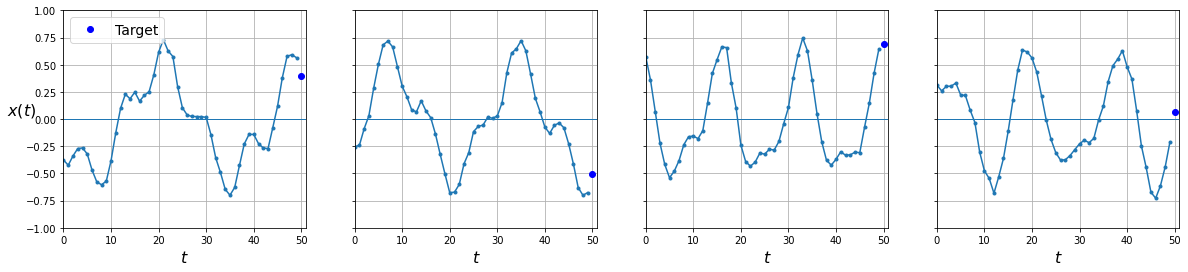

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20, 4))
for col in range(4):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [9]:
ts[0][:10] # First 10 Time stamps of first batch

array([[-0.5394737 ],
       [-0.46692556],
       [-0.42148662],
       [-0.35173497],
       [-0.36864796],
       [-0.27826878],
       [-0.2913451 ],
       [-0.28914467],
       [-0.31381977],
       [-0.33780718]], dtype=float32)

### Preparing Datasets 

The model we gonna train is a Seq2Vec Model. We only let out output the single, next time stamp.

Due to that we let out model generate a series with one value added in the End. This will be our Y.

## Baseline Metric
Before implementing a complex RNN it's usefull first to have a baseline. 

Two options: 

__1. Naive Forecasting__  
    - Just calculate the MSE based on the validation data set
    
__2. Building a very simple model__  
    - Dense Model  
    - Linear Regression Model  
    - ...  

#### Naive Forecasting  (MSE~0.02)

In [56]:
y_pred = x_valid[:,-1]

In [57]:
mse = tf.keras.losses.mean_squared_error(y_pred, y_valid)

In [58]:
np.mean(mse) 

0.2868186

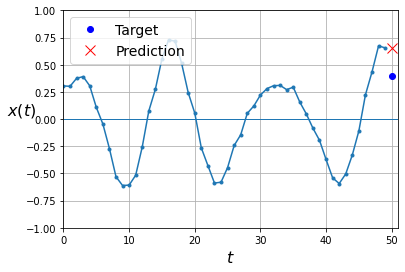

In [59]:
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Building a Dense Model (MSE~0.004)

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [n_steps, 1]),
    tf.keras.layers.Dense(1)
])

In [61]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error)

In [64]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 0s 2ms/step - loss: 0.1465 - val_loss: 0.1542
Epoch 2/5
219/219 [==============================] - 0s 2ms/step - loss: 0.1464 - val_loss: 0.1536
Epoch 3/5
219/219 [==============================] - 0s 2ms/step - loss: 0.1466 - val_loss: 0.1532
Epoch 4/5
219/219 [==============================] - 0s 2ms/step - loss: 0.1466 - val_loss: 0.1538
Epoch 5/5
219/219 [==============================] - 0s 2ms/step - loss: 0.1465 - val_loss: 0.1534


In [72]:
x_valid[0, :, 0]

array([ 0.3050204 ,  0.30152497,  0.3751601 ,  0.39051387,  0.30609563,
        0.10806351, -0.04481836, -0.27120343, -0.53005266, -0.6110558 ,
       -0.6072781 , -0.5164141 , -0.25561166,  0.0748598 ,  0.2749697 ,
        0.5544027 ,  0.7266805 ,  0.7178169 ,  0.5119027 ,  0.24358536,
        0.05559222, -0.26531246, -0.42735794, -0.5883318 , -0.5807008 ,
       -0.44607818, -0.24293604, -0.14431044,  0.0529796 ,  0.12089796,
        0.22094227,  0.2803506 ,  0.3067809 ,  0.30995855,  0.27073693,
        0.29367074,  0.15643366,  0.04640321, -0.08379079, -0.19486697,
       -0.3714829 , -0.54036564, -0.592944  , -0.5041277 , -0.32999223,
       -0.1079238 ,  0.22333595,  0.43406898,  0.67406183,  0.65449286],
      dtype=float32)

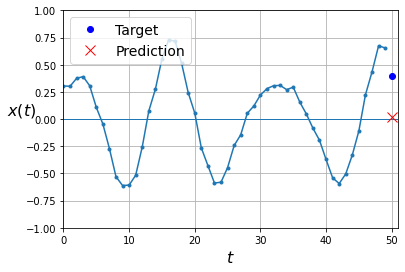

In [67]:
# For the first batch plot prediction and time series
y_pred = model.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0]) # For t
plt.show()

In [73]:
y_pred # Contains the predictions for every batch 

array([[ 0.01789239],
       [-0.03779696],
       [-0.00939745],
       ...,
       [-0.02387949],
       [-0.01084706],
       [ 0.03994339]], dtype=float32)

## Implementing the RNN (Seq2Vec Model)

__return_sequences__: To output the hidden state

In [74]:
rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.Dense(1)
])

In [75]:
rnn.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error)

In [76]:
history = rnn.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 13s 56ms/step - loss: 0.1543 - val_loss: 0.1527
Epoch 2/5
219/219 [==============================] - 12s 56ms/step - loss: 0.1460 - val_loss: 0.1519
Epoch 3/5
219/219 [==============================] - 12s 56ms/step - loss: 0.1458 - val_loss: 0.1516
Epoch 4/5
219/219 [==============================] - 12s 56ms/step - loss: 0.1456 - val_loss: 0.1518
Epoch 5/5
219/219 [==============================] - 12s 56ms/step - loss: 0.1457 - val_loss: 0.1525


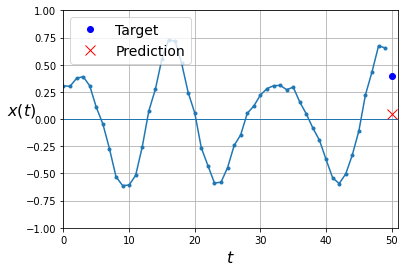

In [77]:
y_pred = rnn.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Comparsion of Models

In [78]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


### Forecasting several time steps ahead (For a Seq2Vec Model)

There are two options: 

1. Predict next value; Append it to the input and predict the next value.

#### 1 Options (Appending predictions to inputs)

In [101]:
series = generate_time_series(1, n_steps+10)

In [103]:
series.shape # We have one batch with 60 time stamps containing one feature

(1, 60, 1)

In [108]:
x_new, y_new = series[:,:n_steps], series[:, n_steps:]

In [109]:
x_new.shape

(1, 50, 1)

In [110]:
y_new.shape

(1, 10, 1)

In [117]:
X = x_new
for i in range(10):
    pred = rnn.predict(X[:,i:]) # Take everything from timestamp i. Because we're gonna append the prediction we need to shift the input always by one. 
    print(X[:,i:].shape)
    print(pred.shape)
    #pred = pred[:, np.newaxis, :]
    print(pred.shape)
    X = np.concatenate([X, pred], axis = 1)
    print(X.shape)
    break
    
    

(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 100, 1)


In [126]:
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:,np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1) # Appending the result to X

In [135]:
y_pred = X[:,n_steps:] # Out Y are the values we appended to X

In [136]:
y_pred

array([[[ 0.09437178],
        [-0.07423237],
        [ 0.03115775],
        [-0.00354035],
        [ 0.10070175],
        [-0.03221845],
        [-0.10235183],
        [ 0.06562433],
        [ 0.06153912],
        [ 0.04254112]]], dtype=float32)

#### Option 2 (Change the output of the last Dense Layer)

-> What's happening here exactly?   
    
    1. We don't have return sequences activated for the last RNN layer. That means this layer outputs only the value of the last time stamp  
    2. It would be better to forecast the next n-values on the last n-timestamps

In [137]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10) # n_steps +1 generate us a label, [batch_size, time_stemps, num_features]
X_train, y_train = series[:7000, :n_steps], series[:7000, -10, 0] # We take the first 7000 Batches for Training, Our Y is everything from the 7000th batch containing only the last value of the ts
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10,0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10,0] 

In [138]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [139]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error)

In [140]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 13s 56ms/step - loss: 0.1572 - val_loss: 0.1497
Epoch 2/5
219/219 [==============================] - 12s 56ms/step - loss: 0.1485 - val_loss: 0.1506
Epoch 3/5
219/219 [==============================] - 12s 55ms/step - loss: 0.1483 - val_loss: 0.1491
Epoch 4/5
219/219 [==============================] - 12s 54ms/step - loss: 0.1481 - val_loss: 0.1497
Epoch 5/5
219/219 [==============================] - 12s 55ms/step - loss: 0.1480 - val_loss: 0.1485


In [141]:
y_pred = model.predict(X_new)

In [142]:
y_pred

array([[-0.03804931, -0.0136443 ,  0.00755197,  0.02146455, -0.02326903,
        -0.02160082, -0.01840174, -0.00405286, -0.04064606, -0.03393946]],
      dtype=float32)

### Option 3 (Seq2Seq)

__Output of the model:__ At Time step 0 the model will output a vector containing the forecasts for time steps 1-10. At Time step 1 the model will forecast the value 1-11  
__Each target is a sequence of the same length as the input__

WE ONLY USE THE LAST TIME STAMP OF THE PREDICTION -> For that we need a own evaluation metric

In [143]:
Y = np.empty((10000, n_steps, 10))

In [148]:
Y.shape # 10.000 batches with 50 time steps each. Containing 10 Features/Targets

(10000, 50, 10)

In [158]:
Y[:,:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [163]:
Y[:,:,0].shape

(10000, 50)

In [162]:
series[:,i:i+n_steps, 0].shape

(10000, 50)

In [160]:
# Range stop is exlusive that means (1,10+1) will output values from 1-10
for i in range(1, 10+1):
    Y[:,:,i-1] = series[:,i:i+n_steps, 0]

In [173]:
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [179]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [180]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:,-1])

In [181]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])

In [182]:
history = model.fit(X_train, Y_train, epochs=5,validation_data=(X_valid, Y_valid))

Epoch 1/5


2021-10-18 13:20:35.657566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


219/219 [==============================] - 5s 11ms/step - loss: 0.0469 - last_time_step_mse: 0.0330 - val_loss: 0.0304 - val_last_time_step_mse: 0.0157
Epoch 2/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0266 - last_time_step_mse: 0.0117 - val_loss: 0.0230 - val_last_time_step_mse: 0.0074
Epoch 3/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0205 - last_time_step_mse: 0.0058 - val_loss: 0.0187 - val_last_time_step_mse: 0.0045
Epoch 4/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0179 - last_time_step_mse: 0.0045 - val_loss: 0.0169 - val_last_time_step_mse: 0.0040
Epoch 5/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0167 - last_time_step_mse: 0.0041 - val_loss: 0.0159 - val_last_time_step_mse: 0.0038


## Multiple forecast (Summary)

There are two options to forecast multiple timestamps ahead. 

__1. Option__ (Seq2Vec)   
    - Using the already trained model and appending iterativly the prediction to the the inputs  
    - Acting if the predicted value actually occured  
    - Predictions in the near future will be more accurate then predictions far away (Errors accumulate)  
__2. Option__ (Seq2Vec) 
    -  Train a separate RNN to predict all 10 next values at once  
__3. Option__ (Seq2Seq)   
    - Let the model forecast 1 time step ahead. TIme step 0 the model will output values from 1-11 and so on.   
    - Only the last time step is important for us! We only use it  
    - Only the last time step can be used for evaluation -> So we need to define a measure for that